In [ ]:
MANUALOPT_FILEPATH = "/content/AubioStudyCOMPLESSIVE - Study2_MANUAL_CSV.csv"
EA_OPT_FILEPATH = "/content/AubioStudyCOMPLESSIVE - Study2_EA_CSV.csv"

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def import_and_findbest(pathtocsv):
    df = pd.read_csv(pathtocsv,sep=',',decimal = '.')
    best_results = dict.fromkeys(pd.unique(df['Method'])) # Create dictionary for results

    for method in best_results.keys():
        best_results[method] = dict.fromkeys(np.sort(pd.unique(df['Buffer Size'])))
        for buffer_size in best_results[method].keys():
            res = dict.fromkeys(['id','method','buffer_size','macroavg_f1'])

            subdf = df.loc[(df['Method'] == method) & (df['Buffer Size'] == buffer_size)]
            if not subdf.empty:
                argmax = subdf['MAvg_t f1'].argmax()
                res['id'] = subdf['ID'].to_numpy()[argmax]
                res['method'] = subdf['Method'].to_numpy()[argmax]
                res['buffer_size'] = subdf['Buffer Size'].to_numpy()[argmax]
                res['macroavg_f1'] = subdf['MAvg_t f1'].to_numpy()[argmax]           # MAvg_t f1 is the third f1 column, containing the macro average between techniques (Look back at Google Sheet)
                res['adj_min'] = subdf['MAvg_t loTukeyFence'].to_numpy()[argmax]
                res['adj_max'] = subdf['MAvg_t hiTukeyFence'].to_numpy()[argmax]
                res['avg'] = subdf['MAvg_t Mean'].to_numpy()[argmax]
                res['percentage'] = subdf['MAvg_t percentageIn'].to_numpy()[argmax]
                res['IQR'] = subdf['MAvg_t IQR'].to_numpy()[argmax]

                best_results[method][buffer_size] = res

        buffersizes = np.sort(pd.unique(df['Buffer Size']))   # Create list of buffer size entries
        methods = best_results.keys()                         # Create list of Aubio methods from the keys of the dict (handy)
    return best_results,buffersizes,methods

EAresults,ea_buffersizes,ea_methods = import_and_findbest(EA_OPT_FILEPATH)
MAresults,man_buffersizes,man_methods = import_and_findbest(MANUALOPT_FILEPATH)

assert ea_buffersizes.all() == man_buffersizes.all()
assert ea_methods == man_methods
assert EAresults != MAresults
buffersizes = ea_buffersizes
methods = ea_methods

In [ ]:
def resultsDict2Dataframe(dz):
    columns = ["buffersize"]+[method for method in dz]
    df = pd.DataFrame(columns=columns)
    methods = [method for method in dz]
    buffersizes = [bs for bs in dz[methods[0]]]
    for buffersize in buffersizes:
        currentRes = []
        for method in methods:
            currentDict = dz[method][buffersize]
            if currentDict:
                currentRes.append(currentDict['macroavg_f1'])
            else:
                currentRes.append(None)
        currentRes = [buffersize]+currentRes
        # print(currentRes)
        df.loc[-1] = currentRes
        df.index = df.index + 1  # shifting index
        df = df.sort_index()  # sorting by index

    df = df.sort_values(by=['buffersize'])
    return df

In [ ]:
def plotComparison(values_A,values_B,name_A, name_B, labels_x,axtitle_x,axtitle_y,title,ylim=None,bar_width = 0.35,horizontal=False):
    assert(len(values_A) == len(values_B))
    index = np.arange(len(values_A))

    fig, ax = plt.subplots()
    if horizontal:
        plotfunction = ax.barh
        ax.invert_yaxis()  # labels read top-to-bottom
        ax.set_ylabel(axtitle_x)
        ax.set_xlabel(axtitle_y)
        ax.set_yticks(index + bar_width / 2)
        ax.set_yticklabels(labels_x)
        if ylim is not None:
            ax.set_xlim(ylim)
    else:
        plotfunction = ax.bar
        ax.set_xlabel(axtitle_x)
        ax.set_ylabel(axtitle_y)
        ax.set_xticks(index + bar_width / 2)
        ax.set_xticklabels(labels_x)
        if ylim is not None:
            ax.set_ylim(ylim)

    plotfunction(index, values_A, bar_width,label=name_A)             # Type 1 bars
    plotfunction(index+bar_width, values_B,bar_width, label=name_B)   # Type 2 bars

    ax.set_title(title)
    ax.legend()

# plotComparison([3,1,2,3,4,5],[0,1,2,1,2,2],"classa","classb",buffersizes,"Buffer size","f1-measure","plotTitle")
# plt.show()

# plotComparison([0.9,0.85],[1,1],"classa","classb",buffersizes,"Buffer size","f1-measure","plotTitle",horizontal=True,ylim=[0.8,1.1])
# plt.show()

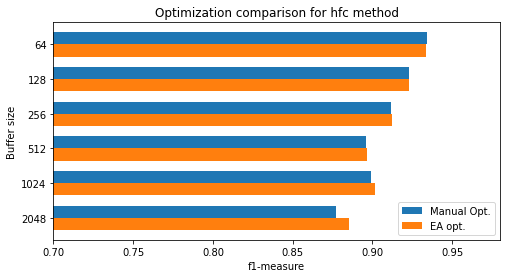

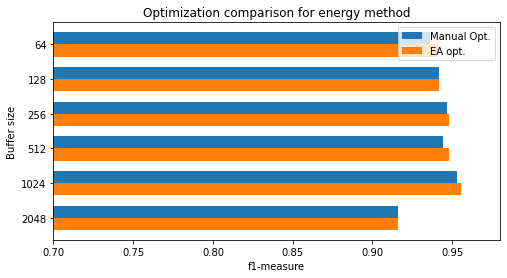

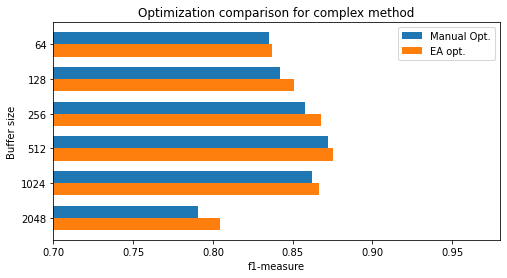

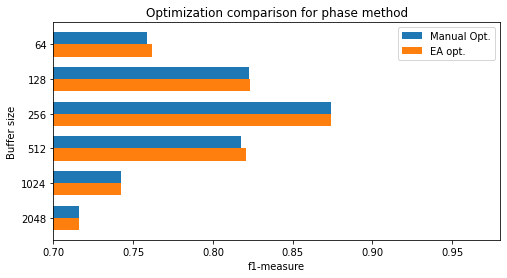

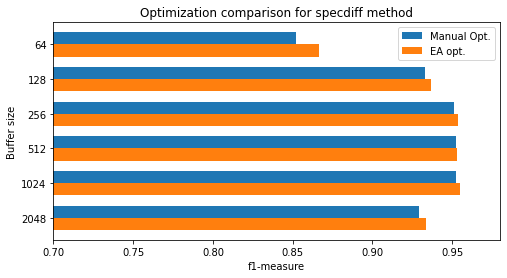

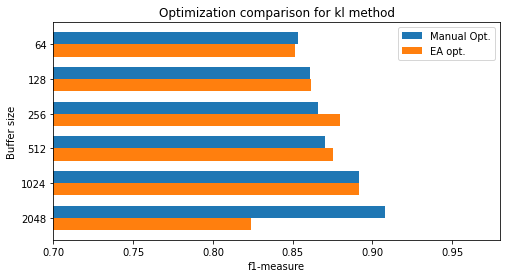

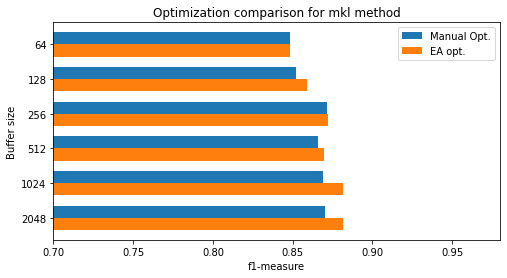

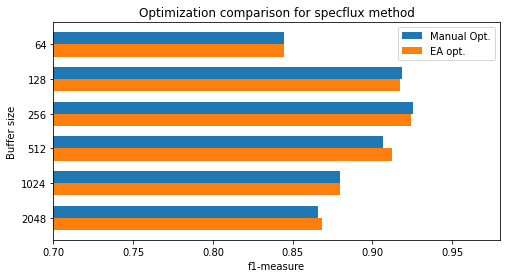

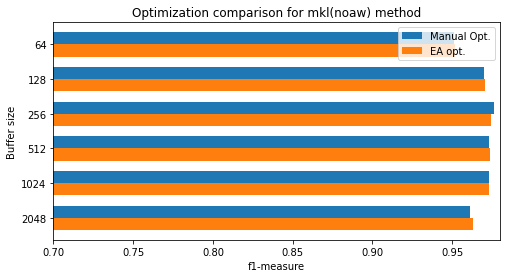

In [ ]:
# plotmethod = 'hfc'
plt.rcParams["figure.figsize"] = (8,4)

for plotmethod in methods:
    listManual = resultsDict2Dataframe(MAresults)[plotmethod].tolist()
    listEa = resultsDict2Dataframe(EAresults)[plotmethod].tolist()
    plotComparison(listManual,listEa,"Manual Opt.","EA opt.",buffersizes,"Buffer size","f1-measure","Optimization comparison for "+str(plotmethod)+" method",ylim=[0.7,0.98],horizontal=True)


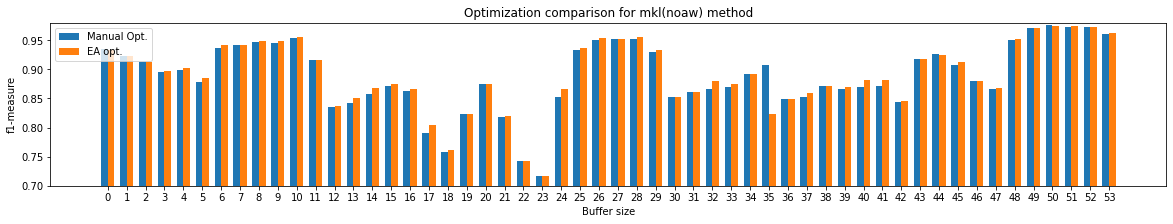

In [ ]:
listManual = []
listEa = []
for plotmethod in methods:
    listManual.append(resultsDict2Dataframe(MAresults)[plotmethod].tolist())
    listEa.append(resultsDict2Dataframe(EAresults)[plotmethod].tolist())

def relist(_list):
    res = []
    for e in _list:
        for v in e:
            res.append(v if v is not None else 0)
    return res

# plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams["figure.figsize"] = (20,3)

plotComparison(relist(listManual),relist(listEa),"Manual Opt.","EA opt.",range(len(relist(listManual))),"Buffer size","f1-measure","Optimization comparison for "+str(plotmethod)+" method",ylim=[0.7,0.98])
plt.show()


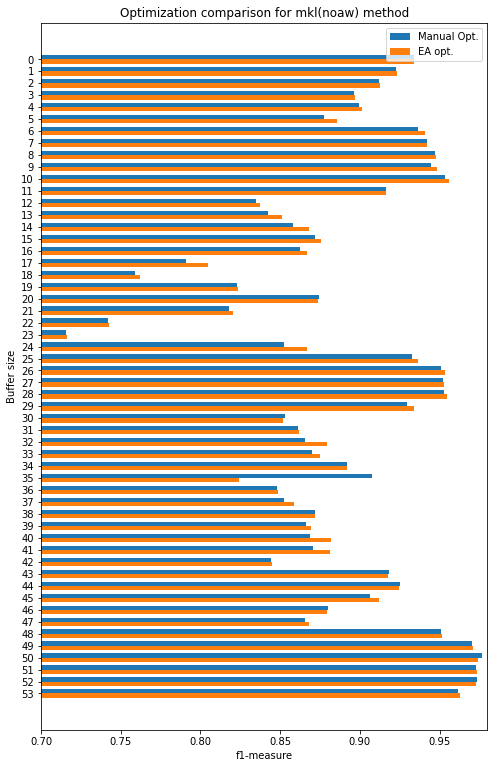

In [ ]:
plt.rcParams["figure.figsize"] = (8,13)
plotComparison(relist(listManual),relist(listEa),"Manual Opt.","EA opt.",range(len(relist(listManual))),"Buffer size","f1-measure","Optimization comparison for "+str(plotmethod)+" method",ylim=[0.7,0.98],horizontal=True)
plt.show()

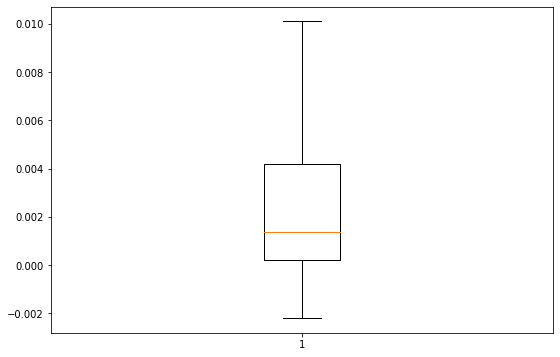

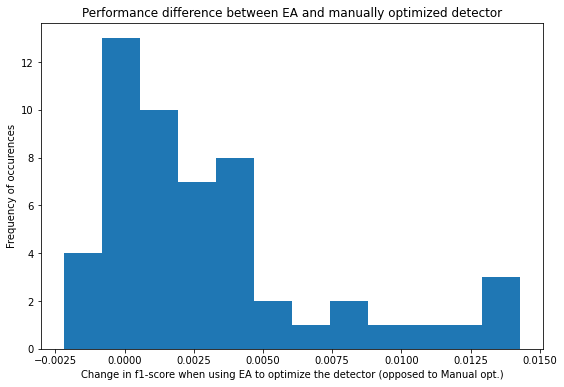

In [ ]:
def remove_outliers(diffs):
    return [d for d in differences if d > -0.05]

differences = [EAresults[mt][bf]['macroavg_f1']-MAresults[mt][bf]['macroavg_f1'] for mt in methods for bf in buffersizes]

plt.boxplot(differences, showfliers=False)
plt.show()

plt.rcParams["figure.figsize"] = (9,6)
fig, ax = plt.subplots()
ax.set_title("Performance difference between EA and manually optimized detector")
ax.set_xlabel("Change in f1-score when using EA to optimize the detector (opposed to Manual opt.)")
ax.set_ylabel("Frequency of occurences")
plt.hist(remove_outliers(differences),bins=12)
# plt.xticks(np.arange(min(differences), max(differences), .02))
# plt.xticks([-.02,-.01,0,0.01,0.02,.03,.04,.05,.06,.07,.08])
plt.show()

# MAresults

In [ ]:
[d for d in differences if d > -0.05]

[-0.08379999999999999]

In [ ]:
methods_col = []
sizes_col = []
manual_col = []
ea_col = []
for method in methods:
    for buffersize in buffersizes:
        methods_col.append(method)
        sizes_col.append(buffersize)
        manual_col.append(EAresults[method][buffersize]["macroavg_f1"])
        ea_col.append(MAresults[method][buffersize]["macroavg_f1"])
tabledf = pd.DataFrame([methods_col,sizes_col,manual_col,ea_col]).transpose().rename({0:"Method",
                                                                                      1:"Buffer Size",
                                                                                      2:"Manual Result",
                                                                                      3:"EA Result"},axis=1)

print(tabledf.to_latex(index=False,label="tb:comparison",caption=""))


\begin{table}
\centering
\caption{}
\label{tb:comparison}
\begin{tabular}{llll}
\toprule
    Method & Buffer Size & Manual Result & EA Result \\
\midrule
       hfc &          64 &        0.9337 &    0.9341 \\
       hfc &         128 &        0.9231 &    0.9229 \\
       hfc &         256 &        0.9126 &     0.912 \\
       hfc &         512 &        0.8968 &    0.8962 \\
       hfc &        1024 &        0.9015 &    0.8993 \\
       hfc &        2048 &        0.8856 &    0.8775 \\
    energy &          64 &         0.941 &    0.9364 \\
    energy &         128 &         0.942 &    0.9419 \\
    energy &         256 &         0.948 &     0.947 \\
    energy &         512 &        0.9482 &    0.9444 \\
    energy &        1024 &        0.9558 &    0.9533 \\
    energy &        2048 &        0.9163 &    0.9164 \\
   complex &          64 &        0.8371 &    0.8351 \\
   complex &         128 &        0.8509 &    0.8422 \\
   complex &         256 &         0.868 &    0.8579 \\
   com